In [1]:
pip install torch torchvision --ignore-installed TBB

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\chloe\\anaconda3\\Library\\bin\\tbbmalloc.dll'
Consider using the `--user` option or check the permissions.



  Using cached torch-2.3.0-cp39-cp39-win_amd64.whl.metadata (26 kB)
  Using cached torchvision-0.18.0-cp39-cp39-win_amd64.whl.metadata (6.6 kB)
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl.metadata (1.1 kB)
  Using cached filelock-3.14.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached typing_extensions-4.11.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
  Using cached pillow-10.3.0-cp39-cp39-win_amd64.whl.metadata (9.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
  Using cached MarkupSafe-2.1.5-cp39-cp39-win_amd64.whl.metadata (3.1 kB)
  Using cached mpmath-

C:\Users\chloe\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [4]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'

train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
def show_transformed_images(loader):
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0])


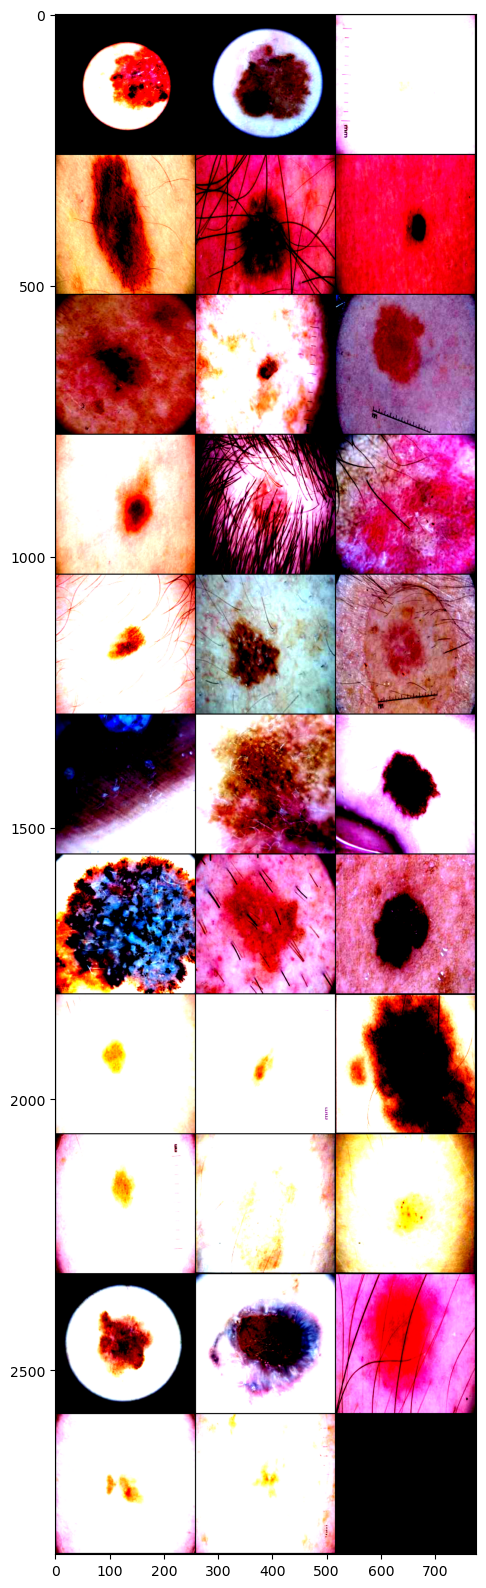

In [7]:
show_transformed_images(train_loader)

In [8]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev="cpu"
    return torch.device(dev)

In [9]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    
    for epoch in range(n_epochs):
        print("Epoch number %d " %(epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.0 * running_correct / total
        
        print("Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
            % (running_correct, total, epoch_acc, epoch_loss))
        
        evaluate_model_on_test_set(model, test_loader)
        
        print("Finished")
        return model

In [10]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    
    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    print("Testing dataset. Got %d out of %d images correctly (%.3f%%)."
            % (predicted_correctly_on_epoch, total, epoch_acc))

In [11]:
resnet18_model = models.resnet18(pretrained=False)
num_features = resnet18_model.fc.in_features
num_classes = 10
resnet18_model.fc = nn.Linear(num_features, num_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chloe\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 20)

Epoch number 1 


KeyboardInterrupt: 

In [ ]:
class MelanomaCNN(nn.Module):
    def __init__(self):
        super(MelanomaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = MelanomaCNN()
criterion = nn.CrossEntropyLoss()
op = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch + 1} loss: {running_loss / len(train_loader)}')


In [ ]:
# Test loop
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total}%')